# EDA – Allegro Reviews

Eksploracyjna analiza danych: dataset opinii z Allegro (KLEJ).

In [15]:
import sys
print("Python:", sys.executable)
print("OK – kernel działa.")
import numpy as np


Python: /Users/jakub/sentiment-classifier-pl/.venv/bin/python
OK – kernel działa.


## Ładowanie danych

In [2]:
from datasets import load_dataset

dataset = load_dataset("allegro/klej-allegro-reviews")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'rating'],
        num_rows: 9577
    })
    validation: Dataset({
        features: ['text', 'rating'],
        num_rows: 1002
    })
    test: Dataset({
        features: ['text', 'rating'],
        num_rows: 1006
    })
})

## Analiza per split (train / validation / test)

In [18]:
# DataFrames dla wszystkich splitów + kolumny długości
train_df = dataset["train"].to_pandas()
val_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()

for df in [train_df, val_df, test_df]:
    df["word_count"] = df["text"].str.split().str.len()
    df["char_count"] = df["text"].str.len()

train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"

all_splits = pd.concat([train_df, val_df, test_df], ignore_index=True)

### Rozkład ocen (liczba i proporcje)

In [19]:
rating_col = "rating"

dist_train = train_df[rating_col].value_counts().sort_index()
dist_val = val_df[rating_col].value_counts().sort_index()
dist_test = test_df[rating_col].value_counts().sort_index()

dist_table = pd.DataFrame({
    "train": dist_train,
    "validation": dist_val,
    "test": dist_test,
}).fillna(0).astype(int)

print("Liczba próbek per ocena i per split:")
display(dist_table)

print("\nProporcje (%) per split:")
for name, df in [("train", train_df), ("validation", val_df), ("test", test_df)]:
    pct = df[rating_col].value_counts(normalize=True).sort_index() * 100
    print(f"\n{name}:")
    print(pct.round(1).to_string())

Liczba próbek per ocena i per split:


,train,validation,test
rating,,,
1.0,1733,209,203
2.0,1069,118,125
3.0,1208,138,144
4.0,1644,201,162
5.0,3923,336,372



Proporcje (%) per split:

train:
rating
1.0    18.1
2.0    11.2
3.0    12.6
4.0    17.2
5.0    41.0

validation:
rating
1.0    20.9
2.0    11.8
3.0    13.8
4.0    20.1
5.0    33.5

test:
rating
1.0    20.2
2.0    12.4
3.0    14.3
4.0    16.1
5.0    37.0


## Rozkład ocen (train vs val vs test)

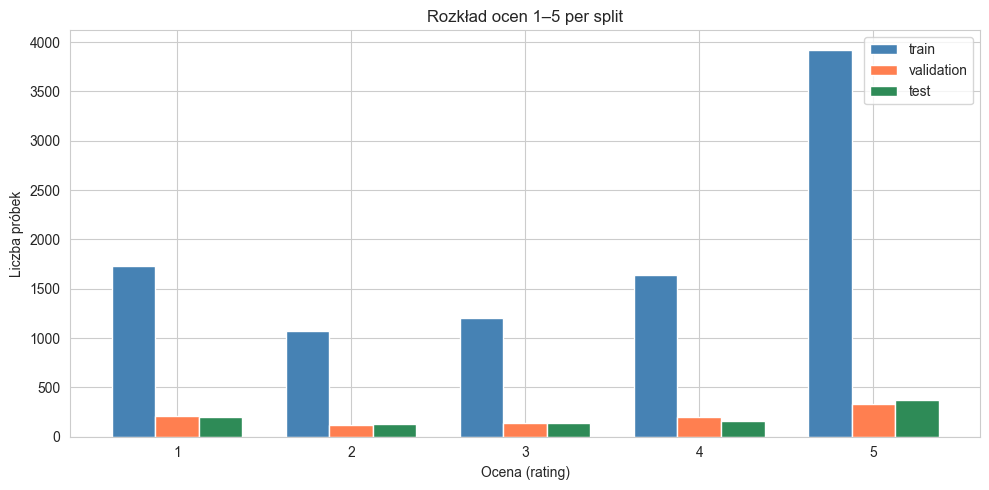

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
x = dist_table.index
width = 0.25
ax.bar(x - width, dist_table["train"], width, label="train", color="steelblue")
ax.bar(x, dist_table["validation"], width, label="validation", color="coral")
ax.bar(x + width, dist_table["test"], width, label="test", color="seagreen")
ax.set_xlabel("Ocena (rating)")
ax.set_ylabel("Liczba próbek")
ax.set_title("Rozkład ocen 1–5 per split")
ax.set_xticks(x)
ax.legend()
plt.tight_layout()
plt.show()

### Statystyki długości (słowa i znaki) per split

In [21]:
def length_stats(df, split_name):
    return pd.Series({
        "n": len(df),
        "słowa_śr": round(df["word_count"].mean(), 1),
        "słowa_med": df["word_count"].median(),
        "słowa_min": df["word_count"].min(),
        "słowa_max": df["word_count"].max(),
        "znaki_śr": round(df["char_count"].mean(), 1),
    }, name=split_name)

length_table = pd.DataFrame([
    length_stats(train_df, "train"),
    length_stats(val_df, "validation"),
    length_stats(test_df, "test"),
])
print("Rozmiary i statystyki długości per split:")
display(length_table)

Rozmiary i statystyki długości per split:


,n,słowa_śr,słowa_med,słowa_min,słowa_max,znaki_śr
train,9577.0,72.6,64.0,0.0,1667.0,477.9
validation,1002.0,73.6,64.0,0.0,547.0,480.9
test,1006.0,73.3,65.0,0.0,302.0,477.2


### Percentyle długości (słowa) – do ustalenia max_length

In [22]:
percentiles = [50, 75, 90, 95, 99]
rows = []
for name, df in [("train", train_df), ("validation", val_df), ("test", test_df)]:
    row = {"split": name, "n": len(df)}
    for p in percentiles:
        row[f"p{p}"] = df["word_count"].quantile(p / 100)
    rows.append(row)
perc_table = pd.DataFrame(rows)
print("Percentyle liczby słów per split:")
display(perc_table)

Percentyle liczby słów per split:


,split,n,p50,p75,p90,p95,p99
0,train,9577,64.0,83.0,115.0,141.00,229.24
1,validation,1002,64.0,82.0,108.9,135.90,217.99
2,test,1006,65.0,81.0,109.0,132.75,207.55


### Długość opinii (słowa) – zoom na typowy zakres

/var/folders/sn/_d058_c16qx8jk31mfwk4gwc0000gn/T/ipykernel_41288/858811310.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


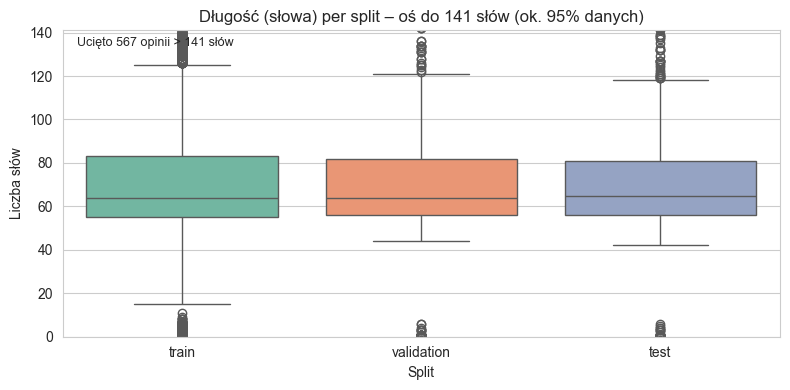

In [23]:
cap = int(np.percentile(train_df["word_count"], 95))

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    data=all_splits, x="split", y="word_count",
    order=["train", "validation", "test"], palette="Set2", ax=ax
)
ax.set_ylim(0, cap)
ax.set_title(f"Długość (słowa) per split – oś do {cap} słów (ok. 95% danych)")
ax.set_ylabel("Liczba słów")
ax.set_xlabel("Split")
n_above = (all_splits["word_count"] > cap).sum()
ax.text(0.02, 0.98, f"Ucięto {n_above} opinii > {cap} słów", transform=ax.transAxes, fontsize=9, va="top")
plt.tight_layout()
plt.show()

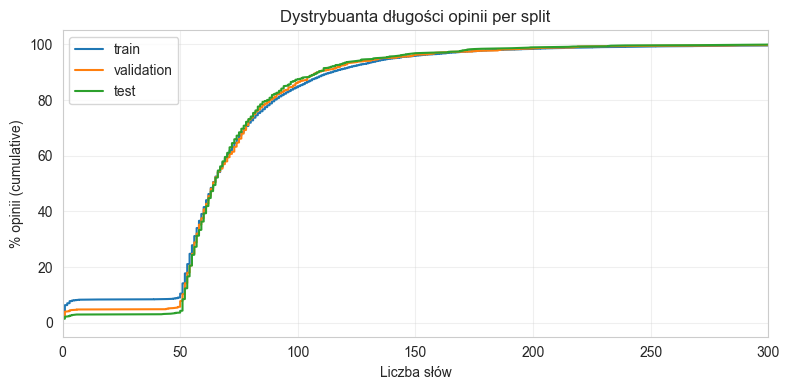

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
for name, df in [("train", train_df), ("validation", val_df), ("test", test_df)]:
    sorted_wc = np.sort(df["word_count"])
    cumul = np.arange(1, len(sorted_wc) + 1) / len(sorted_wc)
    ax.plot(sorted_wc, cumul * 100, label=name)
ax.set_xlim(0, 300)
ax.set_xlabel("Liczba słów")
ax.set_ylabel("% opinii (cumulative)")
ax.set_title("Dystrybuanta długości opinii per split")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Jakość danych: puste teksty i duplikaty

In [25]:
# Puste / prawie puste (0 słów)
empty_train = (train_df["word_count"] == 0).sum()
empty_val = (val_df["word_count"] == 0).sum()
empty_test = (test_df["word_count"] == 0).sum()
print("Opinie z 0 słów:")
print(f"  train: {empty_train}, validation: {empty_val}, test: {empty_test}")

# Duplikaty w obrębie train (ten sam text, może różny rating)
dup_train = train_df["text"].duplicated(keep=False)
n_dup_texts_train = dup_train.sum()
if n_dup_texts_train > 0:
    dup_subset = train_df.loc[dup_train, ["text", "rating"]]
    n_same_text_diff_rating = dup_subset.groupby("text")["rating"].nunique()
    n_same_text_diff_rating = (n_same_text_diff_rating > 1).sum()
    print(f"\nDuplikaty tekstów w train: {n_dup_texts_train} rekordów")
    print(f"  Tekstów z różnymi ocenami (szum): {n_same_text_diff_rating}")
else:
    print("\nDuplikaty tekstów w train: 0")

# Czy teksty z test/val występują w train (leakage)
train_texts = set(train_df["text"])
val_in_train = val_df["text"].isin(train_texts).sum()
test_in_train = test_df["text"].isin(train_texts).sum()
print(f"\nTeksty val występujące w train: {val_in_train}")
print(f"Teksty test występujące w train: {test_in_train}")

Opinie z 0 słów:
  train: 397, validation: 25, test: 14

Duplikaty tekstów w train: 626 rekordów
  Tekstów z różnymi ocenami (szum): 28

Teksty val występujące w train: 25
Teksty test występujące w train: 18


## Wnioski EDA (obserwacje → decyzje)

In [26]:
# Propozycja max_length na podstawie p95 słów w train (później sprawdzisz w tokenach)
p95_train = int(train_df["word_count"].quantile(0.95))
p99_train = int(train_df["word_count"].quantile(0.99))

wnioski = pd.DataFrame([
    {"Obserwacja": "Imbalance: dużo ocen 5 w train", "Decyzja": "F1 macro, class_weight='balanced'"},
    {"Obserwacja": f"p95 słów (train) = {p95_train}, p99 = {p99_train}", "Decyzja": f"max_length: ok. {p95_train}–{p99_train} (zweryfikować w tokenach)"},
    {"Obserwacja": f"Puste teksty: train={empty_train}, val={empty_val}, test={empty_test}", "Decyzja": "Usunąć lub uzupełnić placeholderem w preprocessing"},
    {"Obserwacja": f"Duplikaty train–test: {test_in_train}, val–train: {val_in_train}", "Decyzja": "Brak leakage" if (test_in_train == 0 and val_in_train == 0) else "Sprawdzić duplikaty przed treningiem"},
])
display(wnioski)

,Obserwacja,Decyzja
0,Imbalance: dużo ocen 5 w train,"F1 macro, class_weight='balanced'"
1,"p95 słów (train) = 141, p99 = 229",max_length: ok. 141–229 (zweryfikować w tokenach)
2,"Puste teksty: train=397, val=25, test=14",Usunąć lub uzupełnić placeholderem w preproces...
3,"Duplikaty train–test: 18, val–train: 25",Sprawdzić duplikaty przed treningiem
